# CycleGAN

## Importação de Bibliotecas

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-xejj1m0z
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-xejj1m0z
  Created wheel for tensorflow-examples: filename=tensorflow_examples-94ee1cac7018aadbd1a1afa09505f4760528b0be_-py3-none-any.whl size=268411 sha256=b3de8d3577e9d8056feebf343806448f2b0e37fc87e22c082195e6240edac58f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8zyj4msm/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

#Choose one dataset to learn context translation

You have to uncomment one.



In [ ]:

#dataset = ['cezanne2photo','https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/cezanne2photo.zip']
#dataset = ['ukiyoe2photo','https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/ukiyoe2photo.zip']
#dataset = ['monet2photo','https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip']
dataset = ['vangogh2photo','https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/vangogh2photo.zip']
#dataset = ['summer2winter_yosemite', 'https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/summer2winter_yosemite.zip']

dataset_name = dataset[0]
dataset_link = dataset[1]

#if not exist, get and unzip 
if not os.path.exists(dataset_name + '.zip'):
  !wget $dataset_link   
  
  zip_file = dataset_name + '.zip'
  !unzip -qo $zip_file

!ls $dataset_name/trainA/ | wc -l
!ls $dataset_name/trainB/ | wc -l

--2021-11-17 13:55:01--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/vangogh2photo.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306590349 (292M) [application/zip]
Saving to: ‘vangogh2photo.zip’

vangogh2photo.zip   100%[===================>] 292.39M  1.77MB/s    in 2m 9s   

2021-11-17 13:57:11 (2.26 MB/s) - ‘vangogh2photo.zip’ saved [306590349/306590349]

400
6287


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Target']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)  
  image = tf.image.decode_jpeg(image)
  # Convert both images to float32 tensors
  image = tf.cast(image, tf.float32)
  
  return image

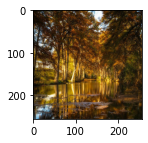

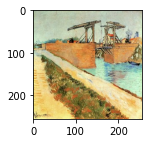

In [ ]:
import glob

#
input_path = glob.glob(dataset_name + '/trainB/*.jpg')
target_path = glob.glob(dataset_name +  '/trainA/*.jpg')

#Reading the first file of input and target
inp = load(input_path[0])
tar = load(target_path[0])

# Casting to int for matplotlib to display the images
plt.figure(figsize=(2,2))
plt.imshow(inp / 255.0)
plt.figure(figsize=(2,2))
plt.imshow(tar / 255.0)

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

#Auxiliary Functions
Below are implemented several auxiliary functions:
  - Crop and Jitter to dataaugmentation
  - Normalization
  - Resize
  - Etc...

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  
  # resizing to +15% to random_crop
  nsize = [int(IMG_HEIGHT*1.15),int(IMG_WIDTH*1.15)]
  
  image = tf.image.resize(image, nsize,
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
@tf.function()
def load_image_train(image_file):  
  image  = load(image_file)
  image = random_jitter(image)
  image = normalize(image)

  return image

In [ ]:
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


  return input_image

In [ ]:
@tf.function()
def load_image_test(image_file):
  image = load(image_file)
  image = resize(image,IMG_HEIGHT, IMG_WIDTH)
  image = normalize(image)

  return image

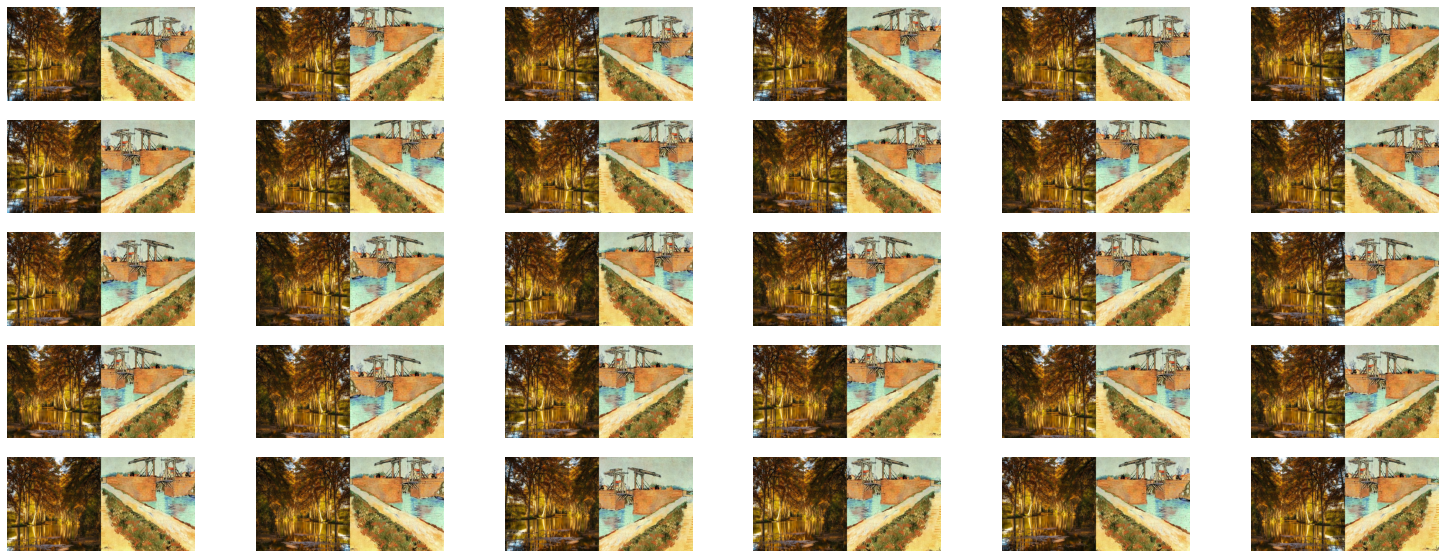

(256, 256, 3)
(256, 256, 3)


In [ ]:
#Here we plot the augmentation result for 30 images
import numpy as np
inp = load(input_path[0])
tar = load(target_path[0])

plt.figure(figsize=(26,10))
plt.subplot(5, 6, 1)
plt.imshow(np.concatenate([inp/255.,tar/255.],axis=1))
plt.axis('off')

for i in range(29):
  
  rj_input, rj_target = random_jitter(inp), random_jitter(tar)
  plt.subplot(5, 6, i + 2)
  plt.imshow(np.concatenate([rj_input/255.,rj_target/255.],axis=1))
  plt.axis('off')
plt.show()

input, target = rj_input, rj_target
print(inp.shape)
print(tar.shape)

In [ ]:
#Here we create the data pipelines from input to target (tf dataset from directories)
PATH = dataset_name
input_dataset = tf.data.Dataset.list_files(PATH + '/trainB/*.jpg')
input_dataset = input_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
input_dataset = input_dataset.shuffle(BUFFER_SIZE)
input_dataset = input_dataset.batch(BATCH_SIZE)

target_dataset = tf.data.Dataset.list_files(PATH + '/trainA/*.jpg')
target_dataset = target_dataset.map(load_image_test,
                                  num_parallel_calls=tf.data.AUTOTUNE)
target_dataset = target_dataset.shuffle(BUFFER_SIZE)
target_dataset = target_dataset.batch(BATCH_SIZE)

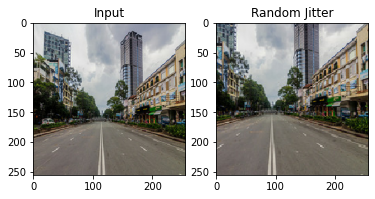

In [ ]:
#Plot an image from input dataset
inp = next(iter(input_dataset))
plt.subplot(121)
plt.title('Input')
plt.imshow(inp[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Random Jitter')
plt.imshow(random_jitter(inp[0]) * 0.5 + 0.5)

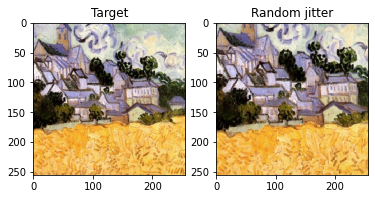

In [ ]:
#Plot an image from target dataset
tar = next(iter(target_dataset))
plt.subplot(121)
plt.title('Target')
plt.imshow(tar[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Random jitter')
plt.imshow(random_jitter(tar[0]) * 0.5 + 0.5)



## Define the generator and discriminator architeture

In [ ]:
InstanceNormalization = pix2pix.InstanceNormalization
downsample = pix2pix.downsample
upsample = pix2pix.upsample

def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
#Instance the discrimintator and generator
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


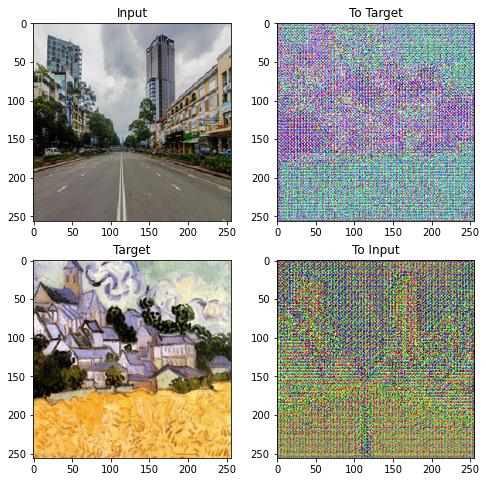

In [ ]:
#Predict an input and a target from a non-trained model
to_input = generator_g(inp)
to_target = generator_f(tar)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [inp, to_target, tar, to_input]
title = ['Input', 'To Target', 'Target', 'To Input']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

## Loss functions

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Inicialização dos otimizadores 

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

Here we define where to save the weights during the training. We recommended a google drive directory to keep the persistency of data in case that you loose the Colab working dir.

It also loads the previous weights if exists, which is helpful in case to continue a stopped training or in the test fase

In [ ]:
#Link to google drive to save permantely the model weigths
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Define path in google drive to save permantely the checkpoint for model recovery
checkpoint_path = "/content/drive/MyDrive/" + dataset_name + "/checkpoints/train"
print(checkpoint_path)
!mkdir -p $checkpoint_path

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

/content/drive/MyDrive/vangogh2photo/checkpoints/train
Latest checkpoint restored!!


## Training



In [ ]:
#Functio that generate images during training
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
#The training pipeline. 
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

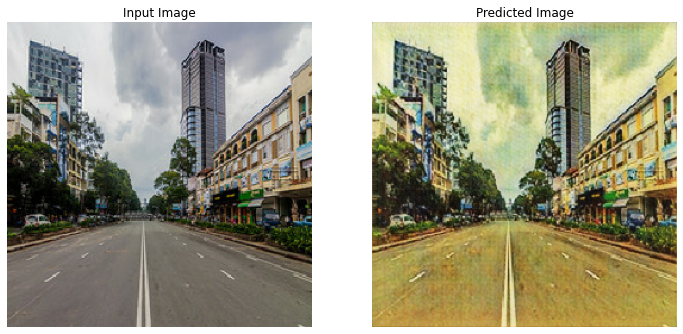

Time taken for epoch 1 is 3562.7293784618378 sec

...

KeyboardInterrupt: ignored

In [ ]:
#Training 100 epochs.
#If the google finish the notebook, you can restart further from the last saving weights (checkpoint)
EPOCHS = 100
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((input_dataset, target_dataset)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, inp)

  if (epoch + 1) % 20 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
        
  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
  
  

## Predicting some images from Input->Target (A->B) according to select dataset 
Examples: 
*  Scene -> Monet
*  Summer -> Winter
*  ... etc






In [ ]:
PATH = dataset_name
test_dataset = tf.data.Dataset.list_files(PATH + '/testB/*.jpg')
test_dataset = test_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Run the trained model on the test dataset
#generator_g : B->A
for test_img in test_dataset.take(5):
  generate_images(generator_g, test_img)

## Predicting some images from Target->Input (B->A) according to select dataset 
Examples: 
*  Monet -> Scene
*  Winter -> Summer
*  ... etc




In [ ]:
PATH = dataset_name
test_dataset = tf.data.Dataset.list_files(PATH + '/trainA/*.jpg')
test_dataset = test_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Run the trained model on the test dataset
#generator_f : A->B
for test_img in test_dataset.take(5):
  generate_images(generator_f, test_img)


#Now test with your own images (Score: 30%)
Take some pictures from the view of your window or your bedroom or anything else!.  I mean, try with several particular scenes that you can capture right now or you can upload some photos that you have.

Try at least 5 scenes and discuss the results. You can use the generator_g only.(Input->Target)

In [ ]:
#implement it here

#Discuss the results obtained about your images (Score 30%). 

It was satisfactory enough ? In both conditions (Yes or No), Do you have a guess to discuss?

Write your answer here: ......



#Final remarks (Score: 40%)

In this work, we have trained a Cycle-Gan network. During the class, we have discussed generative adversarial training and its architectures. To end this work, answer in a few words the questions below. You can write in Portuguese if you want.


1. What is the difference between a discriminative and generative network?

The discriminative model seeks to separate data into classes, using a decision boundary, it is the standard classification task, in the context of this work the discriminative model maps (image -> class).

The generative model learns the distribution of data and can generate new data with the same distribution, plays the role of creating new synthetic data that mimic the characteristics of the original data, in the context of this work the generative model maps (random values -> image).

2. What is the main concept behind GAN's ?

The generative model creates false synthetic data from random values, the discriminative model takes true data and false data and sorts whether the data is true or false, the generative model tries to fool the discriminative model, both models learn together and compete.

Comparing with a classification without the generative model, the use of synthetic examples from the generative model modifies the decision boundary of the discriminative model, improving the result, also increasing the number of examples during training.

3. Describe the main difference between GAN, Conditional GAN and Cycle-Gans. In your discussion try to cover the following points: 

  * What and how each archicture learn?   

The Conditional GAN (C-GAN) uses pairs with the images and also labels, it uses context transfer, the main difference is the addition of the labels; and Cycle-GAN uses unpaired data and also 2 generative models that transform (G:X−>Y) and (F:Y−>X) where G and F are the generative models and X and Y are two groups of images, the Cycle-GAN also uses 2 discriminative models, one for each data group to classify whether they are real or false.

  * When provide a single, paired or unpaired dataset? What is the rationale?

GAN: single data (without labels)

C-GAN: paired (with labels)

Cycle-GAN: unpaired (with labels, but the labels are implicit, each generative model focuses on transforming from one class to another and each discriminative model classifies whether it is true or false for a specific class)

  * What is the final result or their purpose? 

Each architecture has inputs in different formats, but the outputs are similar where the discriminative model classifies true and false, C-GAN gets better results but needs labels, Cycle-GAN serves to train unpaired data.

  * Describe the strongests and bottlenecks of each one.

C-GAN uses context transfer and additional label information and can get better results than GAN without labels but needs annotated data which can be a costly process to create and Cycle-GAN works without label annotation and with unpaired data.

Adding to what was learned during the lesson: In CycleGAN, there is no paired data to train, so there is no guarantee that the x input and the y destination pair are significant during training, this problem gets worse the more different X and Y are, because of this it requires a relatively large amount of data for training and also it needs training for more epochs than other neural networks that use paired data.

